# GOI - Milestone #2 
## Reconstructing The Stochastic Gates Research

Installing dependencies

In [3]:
# %pip install scikit-learn
# %pip install pandas
# %pip install seaborn
# %pip install torch
# %pip install stg 
# %pip install matplotlibv


# Regression

(1000, 20)
(1000, 1)


C:\Users\avivg\AppData\Local\Temp\ipykernel_14348\1496851828.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  ax[0].scatter(x=X_data[:, 0], y=X_data[:, 1], s=150, c=y_data.reshape(-1), alpha=0.4, cmap=plt.cm.get_cmap('RdYlBu'), )
C:\Users\avivg\AppData\Local\Temp\ipykernel_14348\1496851828.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  ax[1].scatter(x=X_data[:, 2], y=X_data[:, 3], s=150, c=y_data.reshape(-1), alpha=0.4, cmap=plt.cm.get_cmap('RdYlBu'), )


Epoch: 1000: loss=0.115617 valid_loss=0.047556
Epoch: 2000: loss=0.067859 valid_loss=0.020820
Epoch: 3000: loss=0.035906 valid_loss=0.006201
(1000, 1)


C:\Users\avivg\AppData\Local\Temp\ipykernel_14348\1496851828.py:67: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  ax[0].scatter(x=X_data[:, 0], y=X_data[:, 1], s=150, c=y_data.reshape(-1), alpha=0.4, cmap=plt.cm.get_cmap('RdYlBu'), )
C:\Users\avivg\AppData\Local\Temp\ipykernel_14348\1496851828.py:71: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  ax[1].scatter(x=X_data[:, 0], y=X_data[:, 1], s=150, c=y_pred.reshape(-1), alpha=0.4, cmap=plt.cm.get_cmap('RdYlBu'), )


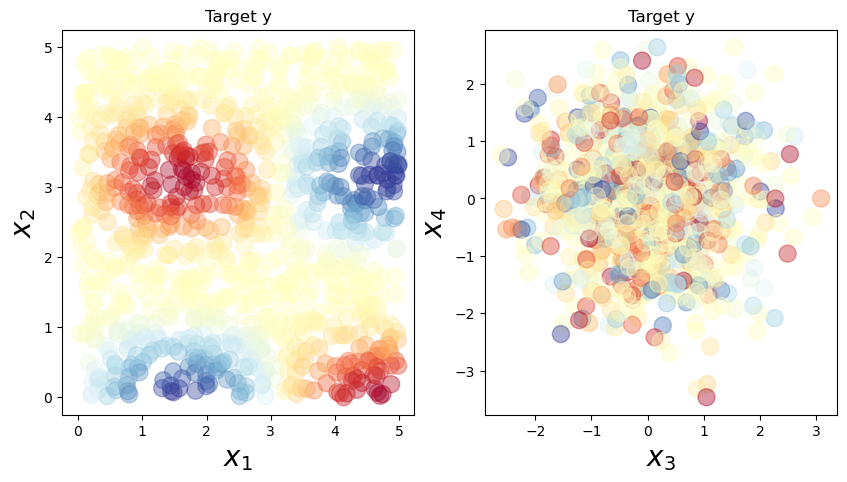

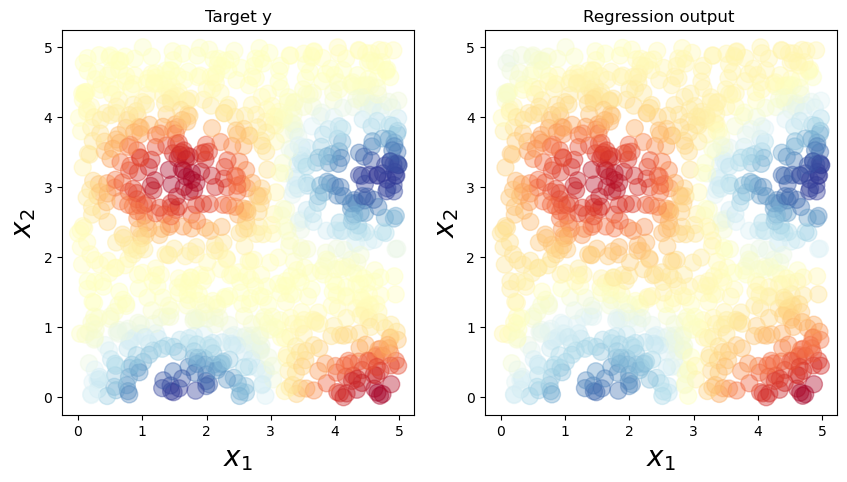

In [16]:
from stg import STG
import numpy as np
import torch
import scipy.stats # for creating a simple dataset
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd

# Create a simple dataset
def create_sin_dataset(n,p):
    x1=5*(np.random.uniform(0,1,n)).reshape(-1,1)
    x2=5*(np.random.uniform(0,1,n)).reshape(-1,1)
    y=np.sin(x1)*np.cos(x2)**3
    relevant=np.hstack((x1,x2))
    noise_vector = scipy.stats.norm.rvs(loc=0, scale=1, size=[n,p-2])
    data = np.concatenate([relevant, noise_vector], axis=1)
    return data, y.astype(np.float32)

n_size = 1000 #Number of samples
p_size = 20   #Number of features
X_data, y_data=create_sin_dataset(n_size,p_size)
print(X_data.shape)
print(y_data.shape)

f, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].scatter(x=X_data[:, 0], y=X_data[:, 1], s=150, c=y_data.reshape(-1), alpha=0.4, cmap=plt.cm.get_cmap('RdYlBu'), )
ax[0].set_xlabel('$x_1$', fontsize=20)
ax[0].set_ylabel('$x_2$', fontsize=20)
ax[0].set_title('Target y')
ax[1].scatter(x=X_data[:, 2], y=X_data[:, 3], s=150, c=y_data.reshape(-1), alpha=0.4, cmap=plt.cm.get_cmap('RdYlBu'), )
ax[1].set_xlabel('$x_3$', fontsize=20)
ax[1].set_ylabel('$x_4$', fontsize=20)
ax[1].set_title('Target y')
plt.tick_params(labelsize=10)

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, train_size=0.9)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, train_size=0.8)

args_cuda = torch.cuda.is_available()
device = torch.device("cuda" if args_cuda else "cpu")
feature_selection = True
model = STG(task_type='regression',input_dim=X_train.shape[1], output_dim=1, hidden_dims=[500, 50, 10], activation='tanh',
    optimizer='SGD', learning_rate=0.1, batch_size=X_train.shape[0], feature_selection=feature_selection, sigma=0.5, lam=0.1, random_state=1, device=device)

model.fit(X_train, y_train, nr_epochs=3000, valid_X=X_valid, valid_y=y_valid, print_interval=1000)

import torch
tmp_loss = torch.nn.MSELoss()
tmp_loss(torch.Tensor(y_train), torch.Tensor(model.predict(X_train)))

tmp_loss(torch.Tensor(y_test), torch.Tensor(model.predict(X_test)))

model.get_gates(mode='prob')

model.get_gates(mode='raw')


## TESTING THE MODEL

y_pred=model.predict(X_data)

print(y_pred.shape)

f, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].scatter(x=X_data[:, 0], y=X_data[:, 1], s=150, c=y_data.reshape(-1), alpha=0.4, cmap=plt.cm.get_cmap('RdYlBu'), )
ax[0].set_xlabel('$x_1$', fontsize=20)
ax[0].set_ylabel('$x_2$', fontsize=20)
ax[0].set_title('Target y')
ax[1].scatter(x=X_data[:, 0], y=X_data[:, 1], s=150, c=y_pred.reshape(-1), alpha=0.4, cmap=plt.cm.get_cmap('RdYlBu'), )
ax[1].set_xlabel('$x_1$', fontsize=20)
ax[1].set_ylabel('$x_2$', fontsize=20)
ax[1].set_title('Regression output ')
plt.tick_params(labelsize=10)
# plt.show()

## Model saving / loading
# Creating dataframes

x = pd.DataFrame(X_data)
y_test1 = pd.DataFrame(y_data)
y_pred1 = pd.DataFrame(y_pred)

# Concatenating along columns and resetting indices

# Resetting indices
x.reset_index(drop=True, inplace=True)
y_test1.reset_index(drop=True, inplace=True)
y_pred1.reset_index(drop=True, inplace=True)
# print(x)
# Concatenating along columns
concatenated_df = pd.concat([x, y_test1, y_pred1], axis=1, ignore_index=True)
#
# print(concatenated_df)

# model.save_checkpoint('trained_model.pt')
# model_tmp = STG(task_type='regression',input_dim=X_train.shape[1], output_dim=1, hidden_dims=[500, 50, 10], activation='tanh',
#     optimizer='SGD', learning_rate=0.1, batch_size=X_train.shape[0], feature_selection=feature_selection, sigma=0.5, lam=0.1, random_state=1, device=device)
#
# model_tmp.load_checkpoint('trained_model.pt')


In [4]:
# from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
import torch
from sklearn.model_selection import train_test_split
from stg import STG  # Assuming this is your custom model import
import matplotlib.pyplot as plt
import os


In [17]:
# # root mean squared error
# rmse = torch.sqrt(tmp_loss(torch.Tensor(y_test_np), torch.Tensor(model.predict(X_test_np))))
# print(f"RMSE: {rmse.item()}")



# Classification

## MADELON Data Set

In [5]:
# Load the MADELON dataset package
path = os.getcwd() + "\madelon.csv"
madelon = pd.read_csv(path)

# Print the first few rows of the DataFrame to verify the data
print(madelon.head())

# Split data into features and target
X = madelon.drop('Class', axis=1)
y = madelon['Class']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert DataFrames to numpy arrays
X_train_np = X_train.to_numpy()
X_test_np = X_test.to_numpy()
y_train_np = y_train.to_numpy()
y_test_np = y_test.to_numpy()

    V1   V2   V3   V4   V5   V6   V7   V8   V9  V10  ...  V492  V493  V494  \
0  485  477  537  479  452  471  491  476  475  473  ...   481   477   485   
1  483  458  460  487  587  475  526  479  485  469  ...   478   487   338   
2  487  542  499  468  448  471  442  478  480  477  ...   481   492   650   
3  480  491  510  485  495  472  417  474  502  476  ...   480   474   572   
4  484  502  528  489  466  481  402  478  487  468  ...   479   452   435   

   V495  V496  V497  V498  V499  V500  Class  
0   511   485   481   479   475   496      2  
1   513   486   483   492   510   517      2  
2   506   501   480   489   499   498      2  
3   454   469   475   482   494   461      1  
4   486   508   481   504   495   511      1  

[5 rows x 501 columns]


In [ ]:
# X_train_np
# X_test_np 
# y_train_np
# y_test_np
# Plotting the results
y_pred_train = model.predict(X_train_np)
y_pred_test = model.predict(X_test_np)

# Calculate confusion matrices for both training and testing sets
y_train_flat = y_train_np.ravel()
y_pred_train_flat = y_pred_train.ravel()

In [6]:

# Define model parameters
args_cuda = torch.cuda.is_available()
device = torch.device("cuda" if args_cuda else "cpu")
feature_selection = True

# Initialize and fit the model
model = STG(task_type='classification',
            input_dim=X_train_np.shape[1],
            output_dim=1,
            hidden_dims=[500, 50, 10],
            activation='tanh',
            optimizer='SGD',
            learning_rate=0.1,
            batch_size=X_train_np.shape[0],
            feature_selection=feature_selection,
            sigma=0.5,
            lam=0.1,
            random_state=1,
            device=device)

model.fit(X_train_np, y_train_np, nr_epochs=3000, valid_X=X_test_np, valid_y=y_test_np, print_interval=1000)


c:\Users\avivg\1My Code Scripts\GeometryOfInformation\.conda\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([2080])) that is different to the input size (torch.Size([2080, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\avivg\1My Code Scripts\GeometryOfInformation\.conda\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([520])) that is different to the input size (torch.Size([520, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 1000: loss=0.333887 valid_loss=0.249970
Epoch: 2000: loss=0.333258 valid_loss=0.249969
Epoch: 3000: loss=0.332864 valid_loss=0.249974


In [7]:
# Evaluate the model
tmp_loss = torch.nn.MSELoss()
train_loss = tmp_loss(torch.Tensor(y_train_np), torch.Tensor(model.predict(X_train_np)))
test_loss = tmp_loss(torch.Tensor(y_test_np), torch.Tensor(model.predict(X_test_np)))

print(f"Train Loss: {train_loss.item()}")
print(f"Test Loss: {test_loss.item()}")


Train Loss: 0.2500940263271332
Test Loss: 0.2499735951423645


c:\Users\avivg\1My Code Scripts\GeometryOfInformation\.conda\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([2080, 1])) that is different to the input size (torch.Size([2080])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\avivg\1My Code Scripts\GeometryOfInformation\.conda\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([520, 1])) that is different to the input size (torch.Size([520])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


## Two Moons Data Set


(1000,)
(1000, 20)
(1000, 20)
(1000,)


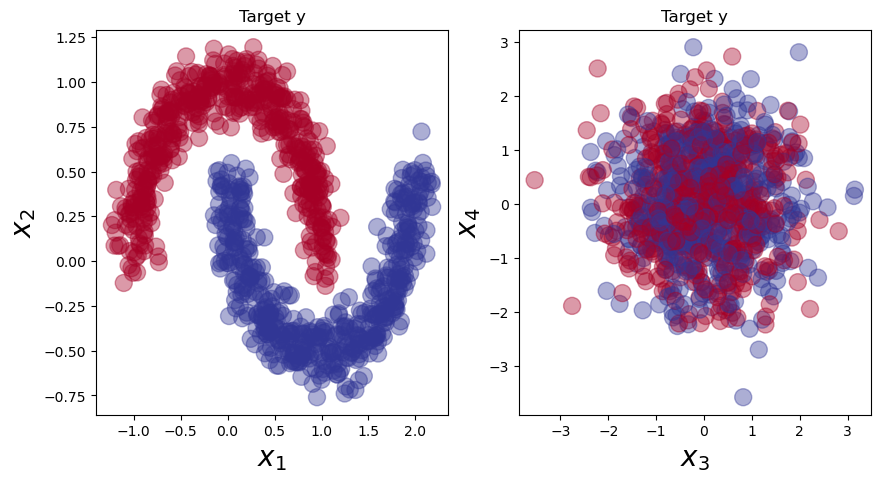

c:\Users\avivg\1My Code Scripts\GeometryOfInformation\.conda\lib\site-packages\torch\nn\modules\module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch: 1000: loss=0.277930 valid_loss=0.192868
Epoch: 2000: loss=0.225879 valid_loss=0.162461
Epoch: 3000: loss=0.068260 valid_loss=0.013376
Epoch: 4000: loss=0.062772 valid_loss=0.009344
Epoch: 5000: loss=0.066544 valid_loss=0.011177
Epoch: 6000: loss=0.060762 valid_loss=0.007496
[1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[ 2.1546     1.6424322 -1.6190051 -1.6141644 -1.6210912 -1.6156664
 -1.6167022 -1.6171824 -1.6186913 -1.6180112 -1.611392  -1.61617
 -1.6168247 -1.6170818 -1.6158788 -1.6168811 -1.6138155 -1.6158236
 -1.6165388 -1.6208644]


In [14]:
from stg import STG
import numpy as np
import scipy.stats # for creating a simple dataset 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons
import torch

import numpy as np
import math
from sklearn.datasets import make_moons
from scipy.stats import norm


# Create a simple dataset
def create_twomoon_dataset(n, p):
    relevant, y = make_moons(n_samples=n, shuffle=True, noise=0.1, random_state=None)
    print(y.shape)
    noise_vector = norm.rvs(loc=0, scale=1, size=[n,p-2])
    data = np.concatenate([relevant, noise_vector], axis=1)
    print(data.shape)
    return data, y

n_size = 1000 #Number of samples
p_size = 20   #Number of features
X_data, y_data=create_twomoon_dataset(n_size,p_size)
print(X_data.shape)
print(y_data.shape)
f,ax = plt.subplots(1,2,figsize=(10,5))
        

ax[0].scatter(x=X_data[:,0], y=X_data[:,1], s=150, c=y_data.reshape(-1),alpha=0.4,cmap=plt.colormaps['RdYlBu'])
ax[0].set_xlabel('$x_1$',fontsize=20)
ax[0].set_ylabel('$x_2$',fontsize=20)
ax[0].set_title('Target y')
ax[1].scatter(x=X_data[:,2], y=X_data[:,3], s=150, c=y_data.reshape(-1),alpha=0.4,cmap=plt.colormaps['RdYlBu'])
ax[1].set_xlabel('$x_3$',fontsize=20)
ax[1].set_ylabel('$x_4$',fontsize=20)
ax[1].set_title('Target y')
plt.tick_params(labelsize=10)
plt.show()

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, train_size=0.3)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, train_size=0.8)


args_cuda = torch.cuda.is_available()
device = torch.device("cuda" if args_cuda else "cpu") 
feature_selection = True
model = STG(task_type='classification',input_dim=X_train.shape[1], output_dim=2, hidden_dims=[60, 20], activation='tanh',
    optimizer='SGD', learning_rate=0.1, batch_size=X_train.shape[0], feature_selection=feature_selection, sigma=0.5, lam=0.5, random_state=1, device=device) 

model.fit(X_train, y_train, nr_epochs=6000, valid_X=X_valid, valid_y=y_valid, print_interval=1000)

print(model.get_gates(mode='prob'))

print(model.get_gates(mode='raw') )


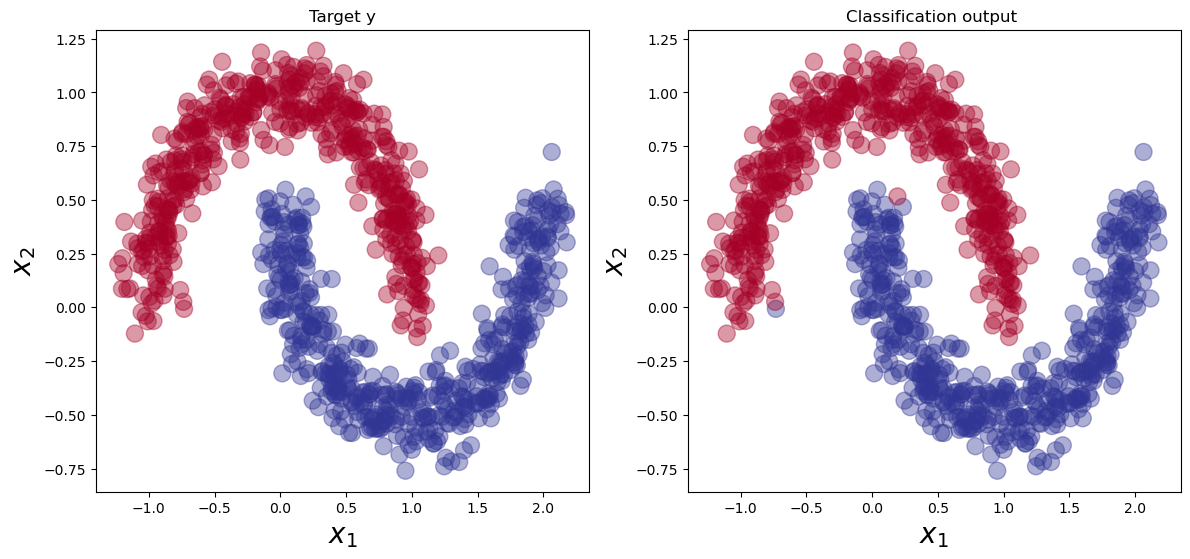

In [15]:
y_pred=model.predict(X_data)
import matplotlib.pyplot as plt
import matplotlib  # Make sure to import this

y_pred = model.predict(X_data)
f, ax = plt.subplots(1, 2, figsize=(14, 6))

ax[0].scatter(x=X_data[:, 0], y=X_data[:, 1], s=150, c=y_data.reshape(-1), alpha=0.4, cmap=matplotlib.colormaps['RdYlBu'])
ax[0].set_xlabel('$x_1$', fontsize=20)
ax[0].set_ylabel('$x_2$', fontsize=20)
ax[0].set_title('Target y')
ax[1].scatter(x=X_data[:, 0], y=X_data[:, 1], s=150, c=y_pred.reshape(-1), alpha=0.4, cmap=matplotlib.colormaps['RdYlBu'])
ax[1].set_xlabel('$x_1$', fontsize=20)
ax[1].set_ylabel('$x_2$', fontsize=20)
ax[1].set_title('Classification output ')
plt.tick_params(labelsize=10)

### Confusion Matrix

In [ ]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

cm = confusion_matrix(y_data, y_pred)
cm = cm / cm.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cm, index=[0, 1], columns=[0, 1])
plt.figure(figsize=(10, 7))
sns.heatmap(df_cm, annot=True, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


NameError: name 'y_data' is not defined

In [ ]:

conf_matrix_train = confusion_matrix(y_train_flat, y_pred_train_flat)
# conf_matrix_test = confusion_matrix(y_test_np, y_pred_test)

# Plot confusion matrix for training set
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Training Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Plot confusion matrix for testing set
plt.subplot(1, 2, 2)
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Testing Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.tight_layout()
plt.show()